In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'project': 'qalf',
    'domain': 'tacred',
    'relation': 'per_title',
    'splits': [0],
    'supervision': 'traditional',
    'max_train': 2000,
#     'max_lfs': 1,
#     'learn_deps': True,
#     'gen_model_search_space': 1,
#     'gen_init_params': {
#         'lf_propensity'         : True,
#         'class_prior'           : True,
#         'lf_class_propensity'   : True,
#         'seed'                  : None,
#     },
#     'gen_params_default': {
#         'step_size'     : 0.0001,
#         'decay'         : 0.90,
#         'reg_param'     : 0.50,
#         'epochs'        : 25,
#     },    
    'disc_model_class': 'logreg',    
    'disc_model_search_space': 1,
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = (config['project'] + '_' + config['domain'] + 
                   ('_' + config['relation'] if config['relation'] else '') +
                   ('_debug' if config.get('debug', False) else ''))
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///qalf_tacred_per_title.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs, get_local_pipeline
config = merge_configs(config)

from snorkel.models import candidate_subclass
candidate_class = candidate_subclass(config['candidate_name'], config['candidate_entities'])

pipeline = get_local_pipeline(config['domain'], config['project'])
pipe = pipeline(session, candidate_class, config)

Overwriting disc_model_search_space=10 to disc_model_search_space=1
Overwriting disc_model_class=lstm to disc_model_class=logreg
Overwriting domain=None to domain=tacred
Overwriting max_sentence_length=100 to max_sentence_length=200
Overwriting rebalance=0.25 to rebalance=False
Overwriting disc_model_search_space=10 to disc_model_search_space=1
Overwriting splits=[0, 1, 2] to splits=[0]
Overwriting max_train=None to max_train=2000
Overwriting disc_model_class=lstm to disc_model_class=logreg
Overwriting supervision=generative to supervision=traditional
Overwriting project=babble to project=qalf
Using TacredQalfPipeline object.


In [5]:
for split in [0,1,2]:
    num_cands = pipe.session.query(pipe.candidate_class).filter(
        pipe.candidate_class.split == split).count()
    print("Split {}: {} Candidates".format(split, num_cands))

Split 0: 5200 Candidates
Split 1: 1935 Candidates
Split 2: 0 Candidates


In [6]:
# %time pipe.parse()

In [7]:
# %time pipe.extract()

In [8]:
# %time pipe.load_gold()

In [9]:
# %time pipe.featurize()

In [10]:
%time pipe.collect()

*QalfPipeline objects load QA result matrices in the label() method.
CPU times: user 109 µs, sys: 124 µs, total: 233 µs
Wall time: 137 µs


In [11]:
%time pipe.label()

> /Users/bradenjh/repos/snorkel/tutorials/qalf/qalf_converter.py(44)convert()
-> with open(mat_path, 'rb') as tsv:
(Pdb) c
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 13.6 s, sys: 291 ms, total: 13.9 s
Wall time: 16.7 s


In [12]:
# from snorkel.annotations import load_gold_labels
# L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
# pipe.L_train.lf_stats(session, labels=L_gold_train)

In [13]:
# from snorkel.annotations import load_gold_labels
# L_gold_dev   = load_gold_labels(session, annotator_name='gold', split=1)
# pipe.L_dev.lf_stats(session, labels=L_gold_dev)

In [14]:
%time pipe.supervise()

In 'traditional' supervision mode...skipping 'supervise' stage.
CPU times: user 196 µs, sys: 121 µs, total: 317 µs
Wall time: 214 µs


In 'traditional' supervision mode...grabbing candidate and gold label subsets.
NOTE: traditional supervision helper assumes all candidates have labels.
Using 2000 traditional gold labels
(2000,)


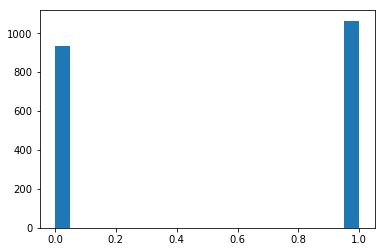

### [7.1] Begin training discriminative model
Skipping grid search.
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=2000  #epochs=20  batch size=128
[SparseLogisticRegression] Epoch 0 (0.07s)	Average loss=0.592741	Dev F1=75.08
[SparseLogisticRegression] Epoch 1 (0.16s)	Average loss=0.502883	Dev F1=74.95
[SparseLogisticRegression] Epoch 2 (0.27s)	Average loss=0.474242	Dev F1=75.69
[SparseLogisticRegression] Epoch 3 (0.37s)	Average loss=0.454843	Dev F1=75.76
[SparseLogisticRegression] Epoch 4 (0.48s)	Average loss=0.437939	Dev F1=75.88
[SparseLogisticRegression] Epoch 5 (0.58s)	Average loss=0.424129	Dev F1=75.55
[SparseLogisticRegression] Epoch 6 (0.68s)	Average loss=0.415995	Dev F1=75.48
[SparseLogisticRegression] Epoch 7 (0.78s)	Average loss=0.409246	Dev F1=74.57
[SparseLogisticRegression] Epoch 8 (0.88s)	Average loss=0.403903	Dev F1=73.76
[SparseLogisticRegression] Epoch 9 (0.98s)	Average loss=0.395950	Dev F1=74.83
[SparseLogisticRegression] Epoch 10 (1.08s

In [15]:
%time pipe.classify()

## Scratch Space

In [16]:
# from snorkel.models import Sentence
# s = pipe.session.query(Sentence).first()
# s.pos_tags

In [17]:
# from spacy.lemmatizer import Lemmatizer
# from spacy.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
# lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
# lemmas = lemmatizer(u'ducks', u'NOUN')
# print(lemmas)

In [18]:
# from spacy.lemmatizer import Lemmatizer
# lemmatizer = Lemmatizer()